Before we get started, you may choose to run this notebook on LEAP-Pangeo hub or Binder!

<a href="https://leap.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fm2lines%2Fdata-gallery&urlpath=lab%2Ftree%2Fdata-gallery%2Fnotebooks%pycnocline_depth_mom6.ipynb&branch=main"><img src="https://custom-icon-badges.demolab.com/badge/LEAP-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:30px;"></a>

<a href="https://mybinder.org/v2/gh/m2lines/data-gallery/main?labpath=notebooks%pycnocline_depth_mom6.ipynb"><img src="https://custom-icon-badges.demolab.com/badge/Binder-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:28px;"></a>

# Pycnocline Depth using MOM6

In this tutorial, we demonstrate how to calculate the zonal-average pycnocline depth in MOM6 data using `xarray` and `xgcm` modules. The codebase is inspired by Dr. Emily Newsom's work in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023GL105673.

In [18]:
import math
import numpy as np
import pandas as pd
import xarray as xr
import gsw as gs
import warnings
import matplotlib
import cftime
from datetime import datetime
from matplotlib import pyplot as plt
from xgcm import Grid

xr.set_options(display_style="html")
plt.rcParams["figure.figsize"] = 5, 2.5
plt.rcParams["text.usetex"] = True

## Load Data File

In [2]:
# !mkdir -p ./data
# !wget -O ./data/N2_ePBL_data_timemean_1978-2002.nc https://github.com/Zanna-ResearchTeam/Pycnocline-depth-MOM6/raw/main/N2_ePBL_data_timemean_1978-2002.nc
# !wget -O ./data/so_ePBL_data_timemean_1978-2002.nc https://github.com/Zanna-ResearchTeam/Pycnocline-depth-MOM6/raw/main/so_ePBL_data_timemean_1978-2002.nc
# !wget -O ./data/thetao_ePBL_data_timemean_1978-2002.nc https://github.com/Zanna-ResearchTeam/Pycnocline-depth-MOM6/raw/main/thetao_ePBL_data_timemean_1978-2002.nc
# !wget -O ./data/ocean_static_rm2.nc https://github.com/Zanna-ResearchTeam/Pycnocline-depth-MOM6/raw/main/ocean_static_rm2.nc

In [3]:
data_dir = "./data/"
file_t = "thetao_ePBL_data_timemean_1978-2002.nc"
file_s = "so_ePBL_data_timemean_1978-2002.nc"
file_n2 = "N2_ePBL_data_timemean_1978-2002.nc"  # we load this only to use the z_i grid in a later step
basin_file = "ocean_static_rm2.nc"
dt = xr.open_dataset(data_dir + file_t)
ds = xr.open_dataset(data_dir + file_s)
dn2 = xr.open_dataset(data_dir + file_n2)
db = xr.open_dataset(data_dir + basin_file)

### Load temperature and salinity

In [4]:
temperature = dt["thetao"].squeeze("time")
salinity = ds["so"].squeeze("time")
basins = db["basin"]

## Calculate potential density relative to pressure: 

We calculate potential density relative to pressure $p$ from Absolute Salinty ($SA$) and Conservative Temperature ($CT$). The results are pretty insensitive to reference pressure. Here we use $p=0$ because it's slightly smoother than using $\sigma_2$ (for $\sigma_2$, use, $p=2000$, PD = gs.density.sigma2(SA,CT))


In [5]:
p = 0
SA = gs.SA_from_SP(salinity, p, salinity.lon, salinity.lat)
CT = gs.CT_from_t(SA, temperature, p)
PD = gs.density.sigma0(SA, CT)

## Calculate $\overline{\rho}_{norm}$ from $\rho^*$:

We calculate $\overline{\rho}_{norm}$ from $\rho^*$, the zonally-averaged potential density below the surface gyres.

\begin{equation*}

\overline{\rho}_{norm}(y,z) = \frac{\overline{\rho^*}(y,B)-\overline{\rho^*}(y,z)}{\mbox{max}_{z}\big(\overline{\rho^*}(y,B)-\overline{\rho^*}(y,z)\big)}

\end{equation*}

In [6]:
lat = -45
ml_depth = 350

pd_no_med = PD.where(basins < 6)  # mask out med and marginal seas

rho_norm = -(pd_no_med.mean("lon") - pd_no_med.mean("lon").max("z_l"))
rho_norm = rho_norm.where(
    rho_norm
    < rho_norm.sel(z_l=ml_depth, method="nearest").sel(lat=lat, method="nearest")
)
rho_norm = rho_norm / rho_norm.max("z_l")
rho_norm = rho_norm.rename("rho_norm")

Plot $\overline{\rho_{norm}}(y,z)$ (left) and depth of the pycnocline ($\overline{\rho_{norm}}=1/e)$ overlaid on zonal average potential density ($\overline{\rho}(y,z)$) (right)

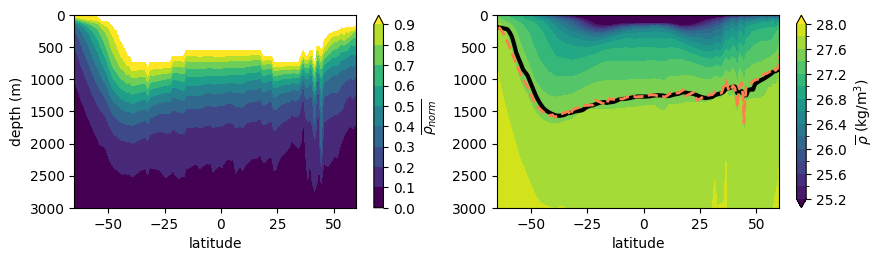

In [7]:
levels1 = np.arange(0, 1, 0.1)
levels2 = np.arange(25.2, 28, 0.2)

fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))

rn = rho_norm.plot.contourf(levels=levels1, add_colorbar=False, ax=axs[0])
cbar1 = plt.colorbar(rn, ax=axs[0])

pd = (
    pd_no_med.mean("lon")
    .rename("potential_density")
    .plot.contourf(levels=levels2, vmin=25, vmax=28.3, add_colorbar=False, ax=axs[1])
)
rho_norm.rolling(lat=5).mean().plot.contour(
    levels=[1 / np.exp(1)], colors="k", linestyles="-", linewidths=3, ax=axs[1]
)
rho_norm.plot.contour(
    levels=[1 / np.exp(1)], colors="coral", linestyles="--", linewidths=2, ax=axs[1]
)
cbar2 = plt.colorbar(pd, ax=axs[1])

for j in range(0, 2):
    axs[j].set_ylim(3000, 0)
    axs[j].set_xlim(-65, 60)
    axs[j].set_xlabel("latitude")
    axs[j].set_title("")


axs[0].set_ylabel("depth (m)")
axs[1].set_ylabel("")
cbar1.set_label(r"$\overline{\rho_{norm}}$")
cbar2.set_label(r"$\overline{\rho}$ (kg/m$^3$)")

## Transform $\rho_{norm}(y,z)$  to $z(y,\rho_{norm})$

The point of doing this is to calculate the average depth, $z$ of a given $\rho_{norm}$ surface, such as $\rho_{norm} =1/e$, i.e., the pycnocline depth by our definition

In [8]:
lat = ds.lat.values
z_l = ds.z_l.values
z_i = dn2.z_i[1:].values

ds_rn = xr.Dataset(
    coords={
        "lat_c": (
            ["lat_c"],
            lat,
        ),
        "lat_g": (
            ["lat_g"],
            lat + 0.5,
        ),
        "z_l": (
            ["z_l"],
            z_l,
        ),
        "z_i": (["z_i"], z_i),
    }
)
grid = Grid(
    ds_rn,
    coords={
        "Y": {"center": "lat_c", "right": "lat_g"},
        "Z": {"inner": "z_l", "outer": "z_i"},
    },
    periodic=False,
)
lev_grid = rho_norm.z_l.broadcast_like(rho_norm)
target_levels = np.arange(0, 1, 0.025)
depth_rho_norm = grid.transform(
    lev_grid, "Z", target_levels, target_data=rho_norm, method="linear"
)

/Users/shubham/anaconda3/envs/DGM2lines/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Plot in Normalized Density - Latitude Space

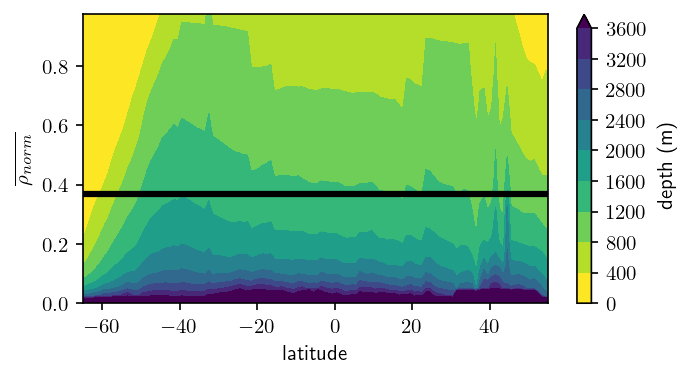

In [23]:
plt.figure(dpi=150)
d = (depth_rho_norm).plot.contourf(
    levels=np.arange(0, 4000, 400), y="rho_norm", cmap="viridis_r", add_colorbar=False
)
plt.hlines(1 / np.exp(1), -70, 60, colors="k", linewidths=3)
plt.ylabel(r"$\overline{\rho_{norm}}$")
plt.xlabel("latitude")
plt.xlim(-65, 55)
cbar = plt.colorbar(d)
cbar.set_label("depth (m)")
plt.title("");

## Calculate Average between 60S to 60N

In [10]:
lats = slice(-60, 60)
pyc_depth = (
    depth_rho_norm.sel(rho_norm=1 / np.exp(1), method="nearest")
    .sel(lat=lats)
    .mean("lat")
)
print("Average pycnocline depth: " + str(np.round(pyc_depth.values)) + " meters")

Average pycnocline depth: 1221.0 meters


## Conclusion

In this notebook, we demonstrate how to load NetCDF files of MOM6 and then using `xarray`, `xgcm` and the work of Dr. Emily Newsom, we are able to extract the pycnocline depth.